In [1]:
%load_ext autoreload
%autoreload 2

# Collaboration and Competition - Unity Tennis Example
# Multi-Agent Deep Deterministic Policy Gradients - MADDPG 

In [2]:
from collections import deque

from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import numpy as np
import torch

from agent import Agent, ReplayBuffer

import time 

## Set everything up

* Parameters
* Unity environment
* Agent

## Parameters

In [3]:
params = {
    'buffer_size': 1e5,
    'batch_size': 256,
    'n_episodes': 1200,
    'random_episodes': 200,
    'max_steps': 1000,
    'update_step': 4,
    'consecutive_update_steps': 3,
    'solution_threshold': .5,
    'eval_window_length': 100,
    'num_agents': 2,
    'agent_seed': 33,
    'env_seed': 33,
    'buffer_seed': 33,
    'gamma': 0.995,
    'tau': 1e-3,
    'lr_actor': 1e-3,
    'lr_critic': 1e-3,
    'critic_weight_decay': 0,
    'noise_sigma': 0.2,
    'noise_scale': 2.0,
    'noise_min_scale': 0.2,
    'noise_scale_decay': 0.99995
}

In [4]:
# Create the unity environment with the tennis application
# Set the random seed for reproduceabilty
env = UnityEnvironment(file_name="Tennis.app",
                       seed=params['env_seed'],
                       no_graphics=False)

# Get the default brain name from the environment
brain_name = env.brain_names[0]

# Save the brain
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
# Reset the environment for the start
env_info = env.reset(train_mode=False)[brain_name]

# Get the number of agents of the specific environment
num_agents = len(env_info.agents)

# Printing the number of agents
print('Number of agents:', num_agents)

# Get the size of the action space
action_size = brain.vector_action_space_size

# Printing the size of the action space
print('Size of each action:', action_size)

# Get the size of the state space
states = env_info.vector_observations
state_size = states.shape[1]

# Printing some information
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:\n', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.93938923 -1.5
 -0.          0.         -7.46356201  6.         -0.          0.        ]


## Instantiate multiple DDPG Agent and Shared Replay Buffer

In [6]:
# Initialize the agents
agents = {}

# For the total number of agents in the environment...
for num_agent in range(params['num_agents']):
    
    # Create one agent to a specific index
    agents[num_agent] = Agent(state_size=state_size, action_size=action_size,
                              agent_no=num_agent, params=params)

# Initialize the shared replay buffer for all agents
replay_buffer = ReplayBuffer(params=params)

## Train the Agent with DDPG (Deep Deterministic Policy Gradients)

### Fill the experience replay buffer with completely random actions

In [7]:
# Get the evaluation window length 
eval_window_lengths = params['eval_window_length']

# Initialize that the environment is not solved
env_is_solved = False

# Initialize the scores
scores = []

# Initialize a list with a fixed length of the window-length
scores_window = deque(maxlen=eval_window_lengths)

# Get the current start time
start = time.time()

# Get the initial scaling for the exploration noise
scale = params['noise_scale']

# Set the random seed
np.random.seed(params['agent_seed'])

# For the maximum number of episodes (for-loop of each episode)... 
for i_episode in range(1, params['random_episodes']+1):
    
    # Initialize the scores for each episode and for each agent with 0
    episode_scores = np.zeros(params['num_agents'])
    
    # Initialize the best score to 0
    best_score = 0
    
    # For each agent reset it...
    for agent in agents.values():
        
        # Reset the current agent
        agent.reset()
        
    # Get the current state of the environment
    states = env_info.vector_observations
    
    # Get the current time of the episode
    episode_start = time.time()
    
    # Reset the environment for the current episode
    env_info = env.reset(train_mode=True)[brain_name]
        
    # Start the current episode...
    for step in range(params['max_steps']):
            
        # Select uniform sampled actions
        actions = np.random.uniform(-1, 1, (params['num_agents'], action_size))
            
        # Perform the actions in the environment
        env_info = env.step(actions)[brain_name]
            
        # Get the new state of all agents
        next_states = env_info.vector_observations
            
        # Get the rewards 
        rewards = env_info.rewards
            
        # Check if a terminal state is reached
        dones = env_info.local_done
            
        # Add the observation/experience to the replay buffer
        replay_buffer.add(states, actions, rewards, next_states, dones)
            
        # Add the current reward to the episode reward
        episode_scores += rewards
            
        # The new state is the current state of the next iteration
        states = next_states
    
        # If a terminal state is reached...
        if np.any(dones):
                
            # End the current episode
            break

### Let the agents train...

In [8]:
# Initialize the best score to 0
best_score = 0

# Initialize the best eval scores to 0
best_eval_score = 0

# For the maximum number of episodes (for-loop of each episode)... 
for i_episode in range(1, params['n_episodes']+1):
    
    # Initialize the scores for each episode and for each agent with 0
    episode_scores = np.zeros(params['num_agents'])
    
    # For each agent reset it...
    for agent in agents.values():
        
        # Reset the current agent
        agent.reset()
        
    # Get the current state of the environment
    states = env_info.vector_observations
    
    # Get the current time of the episode
    episode_start = time.time()
    
    # Reset the environment for the current episode
    env_info = env.reset(train_mode=True)[brain_name]
            
    # Start the current episode..
    for step in range(params['max_steps']):
            
        # Predict the actions with exploration noise of the current state
        actions = [agent.act(env_info.vector_observations[no_agent], scale=scale)
                       for no_agent, agent in enumerate(agents.values())]
            
        # Concatenate all actions of the current state
        actions = np.concatenate(actions, axis=0).reshape((params['num_agents'], action_size))
            
        # Perform the actions in the environment
        env_info = env.step(actions)[brain_name]
            
        # Get the new state
        next_states = env_info.vector_observations
            
        # Get the rewards of the performed actions
        rewards = env_info.rewards
            
        # Check if a terminal state is reached
        dones = env_info.local_done
            
        # Add the current observation/experience to the replay buffer
        replay_buffer.add(states, actions, rewards, next_states, dones)
            
        # Let the agents learn from its experiences
        agent.step(replay_buffer, agents)
            
        # Add the current rewards to the episode rewards
        episode_scores += rewards
            
        # The new state is the current state in the next iteration
        states = next_states
            
        # Adjust the scale of the exploration noise by its decay
        scale = max(params['noise_min_scale'], scale*params['noise_scale_decay'])
            
        # If a terminal state is reached...
        if np.any(dones):
                
            # End of the episode
            break
    
    # Calculate the buffer ratio by the current size and the total size
    buffer_load_ratio = len(replay_buffer)/replay_buffer.buffer_size
    
    # Get the episode duration 
    episode_duration = time.time() - episode_start
    
    # Get the maximum episode reward
    score = max(episode_scores)
    
    # Append the maximum episode reward to the evaluation buffer
    scores.append(score)
    
    # Save the scores
    #np.save('maddpg_scores', scores)
    
    # Append the maximum episode reward to the evaluation buffer
    scores_window.append(score)
    
    # Print the current score of the episode, the buffer load ratio, the current noise scaling and the duration of the current episode
    print('\rEpisode {:4d} - Score: {:.2f} - Buffer Load Ratio: {:.1%} - Noise Scale: {:.2f} - Duration: {:.1f}[s]'.format(
        i_episode, score, buffer_load_ratio, scale, episode_duration), end="")
    
    # Every "eval_window_length" episodes...
    if i_episode % params['eval_window_length'] == 0:
            
            # Printing the average score over "eval_window_length", the buffer load ratio and the total time since the start of the training
            print('\rEpisode {:4d} - Average Score: {:.2f} - Buffer Load Ratio: {:.1%} - Total Time since Start: {:4d}[s]'.format(
                i_episode, np.mean(scores_window), buffer_load_ratio, int(time.time() - start)))
    
    # If the solution threshold is reached...
    if (np.mean(scores_window) >= params['solution_threshold']) & (not env_is_solved):
        
        # Print the Average score and the current episode
        print('\nEnvironment solved in {:4d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                      np.mean(scores_window)))
        
        # Save that the environment is solved...
        env_is_solved = True
    
    # If the environment is solved and the current score is better than the best_score...
    if env_is_solved & (score > best_score):
            
            # Save the best score
            best_score = score
            
            # Reset the environment
            env_info = env.reset(train_mode=False)[brain_name]
            
            # Initialize the eval scores
            episode_eval_scores = np.zeros(params['num_agents'])
            
            # Start the eval episode..
            for step in range(params['max_steps']):
    
                # Predict the actions with exploration noise of the current state
                actions = [agent.act(env_info.vector_observations[no_agent], scale=0)
                               for no_agent, agent in enumerate(agents.values())]

                # Concatenate all actions of the current state
                actions = np.concatenate(actions, axis=0).reshape((params['num_agents'], action_size))

                # Perform the actions in the environment
                env_info = env.step(actions)[brain_name]

                # Get the new state
                next_states = env_info.vector_observations

                # Get the rewards of the performed actions
                rewards = env_info.rewards

                # Check if a terminal state is reached
                dones = env_info.local_done

                # Add the current rewards to the episode rewards
                episode_eval_scores += rewards

                # The new state is the current state in the next iteration
                states = next_states

                # If a terminal state is reached...
                if np.any(dones):

                    # End of the episode
                    break
            
            # Get the maximum of the eval episode scores
            eval_score = max(episode_eval_scores)
            
            if eval_score > best_eval_score:
                best_eval_score = eval_score
                # For all agents...
                for no, agent in agents.items():
                    # Save the best actor
                    torch.save(agent.actor_local.state_dict(), 'agent_{}_best_actor_e_{}.pth'.format(no, i_episode))

                    # Save the best critic
                    torch.save(agent.critic_local.state_dict(), 'agent_{}_best_critic_e_{}.pth'.format(no, i_episode))

# Print the episode, step and maximum of scores
print('Score (max over agents) from episode {} ({} steps): {}'.format(i_episode, step, np.max(scores)))

/Users/pschulte/Inovex/Git/reinforcement_learning_projects 2/MADDPG Tennis/agent.py:259: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(agent.critic_local.parameters(), 1)


Episode  100 - Average Score: 0.01 - Buffer Load Ratio: 5.4% - Total Time since Start:  134[s]
Episode  200 - Average Score: 0.02 - Buffer Load Ratio: 7.1% - Total Time since Start:  265[s]
Episode  300 - Average Score: 0.01 - Buffer Load Ratio: 8.8% - Total Time since Start:  393[s]
Episode  400 - Average Score: 0.04 - Buffer Load Ratio: 11.0% - Total Time since Start:  566[s]
Episode  500 - Average Score: 0.07 - Buffer Load Ratio: 14.2% - Total Time since Start:  811[s]
Episode  600 - Average Score: 0.11 - Buffer Load Ratio: 18.8% - Total Time since Start: 1216[s]
Episode  700 - Average Score: 0.15 - Buffer Load Ratio: 24.8% - Total Time since Start: 1939[s]
Episode  800 - Average Score: 0.16 - Buffer Load Ratio: 30.4% - Total Time since Start: 2569[s]
Episode  873 - Score: 1.60 - Buffer Load Ratio: 49.0% - Noise Scale: 0.21 - Duration: 64.8[s]]
Environment solved in  873 episodes!	Average Score: 0.51
Episode  900 - Average Score: 0.70 - Buffer Load Ratio: 57.5% - Total Time since St

In [9]:
# Close the environment after running
env.close()

## Performance Plot

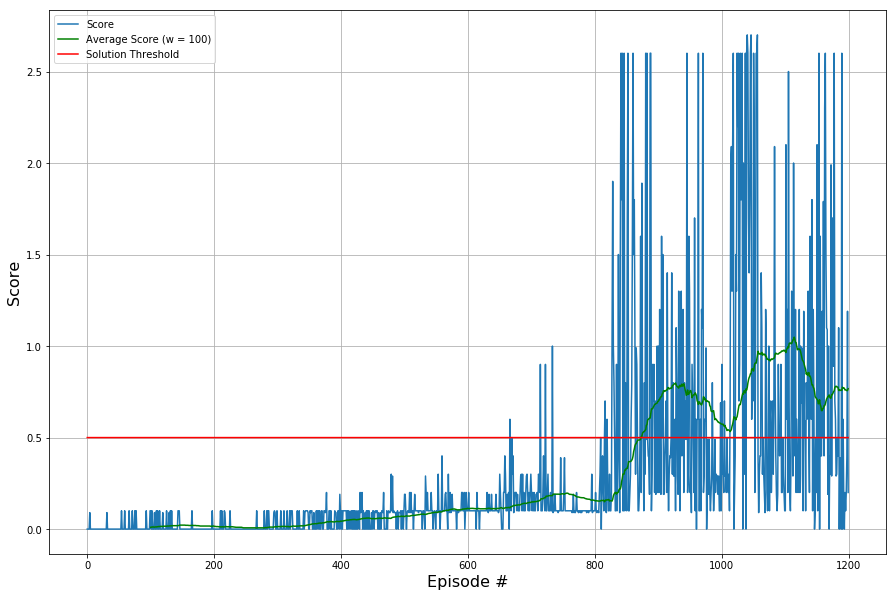

In [11]:
average_scores = np.array([np.mean(scores[i:(i+params['eval_window_length'])])
                           for i in range(len(scores)-params['eval_window_length'])])
steps = len(scores)

fig = plt.figure(figsize=(15, 10))
plt.plot(np.arange(steps), scores, linewidth=1.5)
plt.plot(np.arange(params['eval_window_length'], steps), average_scores, 'g-')
plt.plot(np.arange(steps), [params['solution_threshold']]*steps, 'r-')
plt.ylabel('Score', fontsize=16)
plt.xlabel('Episode #', fontsize=16)
plt.legend(['Score', 'Average Score (w = 100)', 'Solution Threshold'])
plt.grid(True)
plt.show()

In [12]:
print("Environment was solved in Episode {}!".format(
      np.argmax((average_scores >= params['solution_threshold']))+params['eval_window_length']))

Environment was solved in Episode 873!


In [14]:
print("First Episode with Agent-Average Score >= 0.5: {}!".format(
      np.argmax(np.array(scores) >= params['solution_threshold'])))

First Episode with Agent-Average Score >= 0.5: 666!
